# 3F8 Binary Classifier 

This notebook is my implementation of the 3F8 coursework. A few of the plotting functions are adapted versions of those provided in the supplementary code.


## The Data ##

We start by importing the required modules as well as the data

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.model_selection as skms
import sklearn.metrics as skme

In [2]:
X = np.loadtxt('X.txt')
Y = np.loadtxt('Y.txt')

In [3]:
X.shape

(1000, 2)

In [4]:
Y.shape

(1000,)

The data consist of 1000 2D data points, X, and 1000 associated labels, Y.

In [5]:
np.unique(Y)

array([0., 1.])

As expected, the data is binary, i.e. there are two classes.

<function matplotlib.pyplot.show(close=None, block=None)>

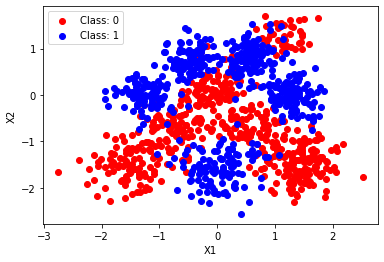

In [6]:
def plot_classes_2D(x, y, c):
    """
        Produces a labelled scatter plot of 2D data
        
        Inputs: X - an (Nx2) array of datapoints
                Y - a length N array of associated labels
                c - a length 2 array of matplotlib colour codes
                
        Outputs: None
    """
    ax = plt.gca()
    for index, label in enumerate(np.unique(y)):
        x1 = [x[i,0] for i in range(x.shape[0]) if y[i] == label]
        x2 = [x[j,1] for j in range(x.shape[0]) if y[j] == label]
        ax.scatter(x1, x2, c=colours[index], label='Class: '+str(int(label)))
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()

colours = ['r', 'b']
plot_classes_2D(X, Y, colours)
plt.show

The data clearly has a very non-linear decision boundary, and so a logistic regression using only the linear input data is unlikely to perform well.

## Training a basic logistic model ##
First we define some useful functions for the training:

Logistic function:
$\sigma(v) = \frac{1}{1+e^{-v}}$

Log-likelihood:
$log \; p(y | X, \beta) = \sum_n y^{(n)}\sigma(\beta^TX) + (1-y^{(n)})(1-\sigma(\beta^TX))$

Gradient of the log-likelihood:
$\nabla log \; p(y | X, \beta) = \sum_n x^{(n)}(y^{(n)}-\sigma(\beta^TX))$

In [7]:
def logistic(z):
    """
        Sigmoid function
        
        Inputs: z - a numerical input to the function
        Output: sigmoid
    """
    return 1. / (1. + np.exp(-1*z))

def create_X_tilde(x):
    """
        Prepends a column of 1's to the array X
        
        Inputs: x - array of 2D data to form x_tilde
        Output: x_tilde
    """
    ones = np.ones((x.shape[0], 1))
    return np.concatenate((ones, x), axis=1)

def calc_grad(beta, x, y):
    """
    Computes the numerical expression derived elsewhere for the grad of the log-likelihood

    Inputs: beta - current weight values
            x - x_tilde, i.e. data array x with column of 1's prepended
            y - class labels for x
    Output: Grad
    """
    dot_prod = np.matmul(x, beta)
    sigmas = logistic(dot_prod)
    #return np.dot(x.T, (np.multiply(y, 1-sigmas) - np.multiply(1-y, sigmas)))
    return np.dot(x.T, y - sigmas)

def calc_likelihood(beta, x, y):
    """
        Computes the numerical expression derived elsewhere for the log-likelihood
        
        Inputs: beta - current weight values
                x - x_tilde, i.e. data array x with column of 1's prepended
                y - class labels for x
        Output: log-likelihood
    """
    dot_prod = np.matmul(x, beta)
    sigmas = logistic(dot_prod)
    return np.dot(y.T, np.log(sigmas)) + np.dot((1-y).T, np.log(1-sigmas).T)

We use scikitlearn to randomly split the data for testing purposes

In [8]:
X_train, X_test, Y_train, Y_test = skms.train_test_split(X, Y, train_size=0.8)
X_tilde_train = create_X_tilde(X_train)
X_tilde_test = create_X_tilde(X_test)

The basic process for training our beta is gradient ascent. We update beta after each iteration to be it's old value plus the scaled grad at that location

In [9]:
learning_rate = 0.0001
steps = 500
def train_model(x_tilde_train, y_train, x_tilde_test, y_test, alpha, n):
    beta = np.random.normal(size=x_tilde_train.shape[1])
    lls_train = np.ones(n)
    lls_test = np.ones(n)
    for i in range(n):
        beta = beta + alpha * calc_grad(beta, x_tilde_train, y_train)
        ll_train = calc_likelihood(beta, x_tilde_train, y_train)/x_tilde_train.shape[0]
        lls_train[i] = ll_train
        ll_test = calc_likelihood(beta, x_tilde_test, y_test)/x_tilde_test.shape[0]
        lls_test[i] = ll_test
    return beta, lls_train, lls_test

def plot_likelihoods(ll_train, ll_test, n):
    axis = np.arange(n)
    plt.plot(axis, ll_train, label='Train')
    plt.plot(axis, ll_test, label='Test')
    plt.xlabel('Iterations')
    plt.ylabel('Average log-likelihood')
    plt.legend(loc='right')
    plt.show()

The choice of learning_rate and steps have largely been trial and error. If the learning rate is too small then beta never converges, if it is too large then it tends to oscillate.
Additionally if we choose to use too many steps then beta tends to grow unbouded. This is because in each iteration we add a very small term to beta (which will be non-zero when our choice of learning rate is not good enough). A possible improvement to this is to add a regularisation term to the log-likelihood

In [10]:
betas, likelihoods_train, likelihoods_test = train_model(X_tilde_train, Y_train, X_tilde_test, Y_test, learning_rate, steps)


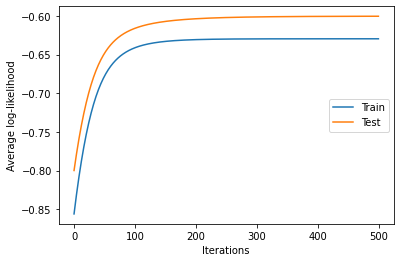

In [11]:
plot_likelihoods(likelihoods_train, likelihoods_test, steps)

In [12]:
likelihoods_train[-1]

-0.6295111619556951

In [13]:
likelihoods_test[-1]

-0.6003325180225938

The log-likelihood converges well.

In [14]:
betas

array([ 0.31117734, -0.09483399,  0.76585461])

In [15]:
def plot_predictive_distribution(x, y, betas, map_inputs = lambda x : x):
    plot_classes_2D(x, y, colours)
    x_min, x_max = x[ :, 0 ].min() - .5, x[ :, 0 ].max() + .5
    y_min, y_max = x[ :, 1 ].min() - .5, x[ :, 1 ].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    ax = plt.gca()
    new_x_tilde = create_X_tilde(map_inputs(np.concatenate((xx.ravel().reshape((-1, 1)), yy.ravel().reshape((-1, 1))), 1)))
    Z = logistic(np.dot(new_x_tilde, betas))
    Z = Z.reshape(xx.shape)
    cs2 = ax.contour(xx, yy, Z, cmap = 'RdBu', linewidths = 2)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 14)

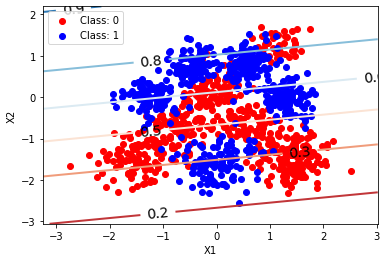

In [16]:
plot_predictive_distribution(X, Y, betas)

The logistic regression performs moderately. It is unable to properly explain the lower class 1 group and so seems to ignore it.

In [17]:
def predict(X_tilde, beta):
    return logistic(np.dot(X_tilde, beta))

def decision(probs):
    return np.array([prob>0.5 for prob in probs]).astype(int)

In [18]:
predictions = predict(create_X_tilde(X_test), betas)
decisions = decision(predictions)

In [19]:
def confusion_matrix(y_true, y_pred):
    return skme.confusion_matrix(y_true, y_pred, normalize='all')

In [20]:
confusion_matrix(Y_test, decisions)

array([[0.37 , 0.155],
       [0.125, 0.35 ]])

## Radial Basis Functions ##

In [21]:
def evaluate_basis_functions(l, X, Z):
        X_sq = np.sum(X**2, 1) # length N array of sum of squares of each row
        Z_sq = np.sum(Z**2, 1)
        ones_X = np.ones(X.shape[0])
        ones_Z = np.ones(Z.shape[0])

        distance = np.outer(X_sq, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z_sq)
        return np.exp(-(0.5 / l**2) * distance)

def metrics(lls_train, lls_test, beta, n, x, x_train, x_test, y, y_test, l):
    plot_likelihoods(lls_train, lls_test, n)
    plt.show()
    plot_predictive_distribution(x, y, beta, lambda x : evaluate_basis_functions(l, x, x_train))
    plt.show()
    decisions = decision(predict(create_X_tilde(evaluate_basis_functions(l, x_test, x_train)), beta))
    print(confusion_matrix(y_test, decisions))

el = 0.01

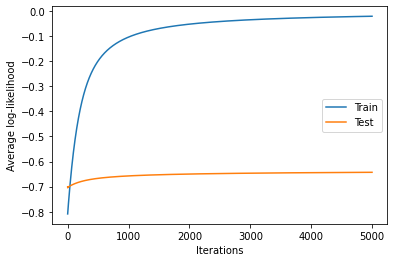

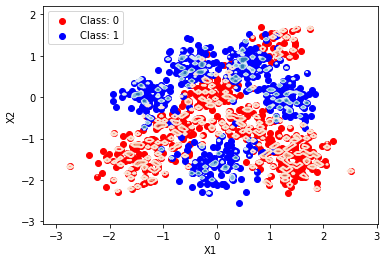

[[0.52  0.005]
 [0.38  0.095]]


In [22]:
l = 0.01
learning_rate = 0.01
steps = 5000
X_tilde_train = create_X_tilde(evaluate_basis_functions(l, X_train, X_train))
X_tilde_test = create_X_tilde(evaluate_basis_functions(l, X_test, X_train))
betas, likelihoods_train, likelihoods_test = train_model(X_tilde_train, Y_train, X_tilde_test, Y_test, learning_rate, steps)
metrics(likelihoods_train, likelihoods_test, betas, steps, X, X_train, X_test, Y, Y_test, l)

In [23]:
print(likelihoods_train[-1], likelihoods_test[-1])

-0.020564713226181076 -0.6427965028316629


With l=0.01, the length scale for the Gaussian RBF is arguably too small. The model is fitting to individual data points and cannot caputre the behaviour of the classes as a whole. Strangely, the model produces a significant amount of false negatives.

el = 0.1

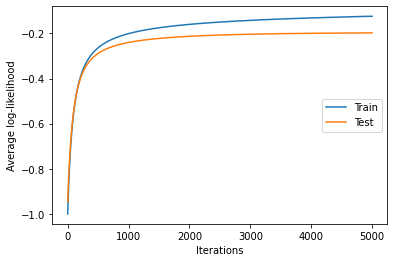

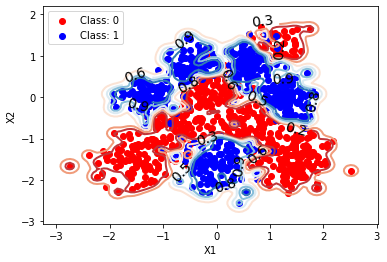

[[0.495 0.03 ]
 [0.05  0.425]]


In [24]:
l = 0.1
learning_rate = 0.001
steps = 5000
X_tilde_train = create_X_tilde(evaluate_basis_functions(l, X_train, X_train))
X_tilde_test = create_X_tilde(evaluate_basis_functions(l, X_test, X_train))
betas, likelihoods_train, likelihoods_test = train_model(X_tilde_train, Y_train, X_tilde_test, Y_test, learning_rate, steps)
metrics(likelihoods_train, likelihoods_test, betas, steps, X, X_train, X_test, Y, Y_test, l)

In [25]:
print(likelihoods_train[-1], likelihoods_test[-1])

-0.12388062208482133 -0.19766119825405107


l=0.1 seems to be a better length scale. The contours encircle clusters of points, rather than individual points. The model does, however, still seem to overfit the training data, likely due to the lack of regularisation. The confusion matrix shows that roughly 87.5% of test points were correctly labelled.

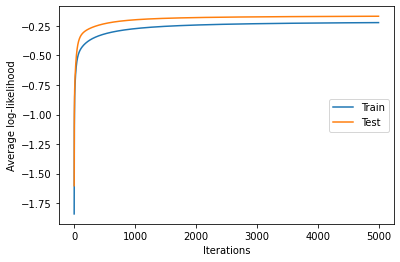

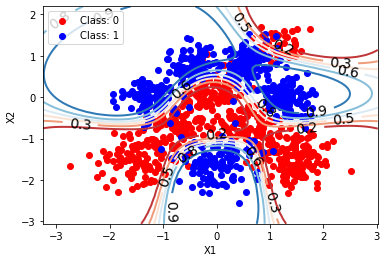

[[0.485 0.04 ]
 [0.02  0.455]]


In [26]:
l = 1
learning_rate = 0.0001
steps = 5000
X_tilde_train = create_X_tilde(evaluate_basis_functions(l, X_train, X_train))
X_tilde_test = create_X_tilde(evaluate_basis_functions(l, X_test, X_train))
betas, likelihoods_train, likelihoods_test = train_model(X_tilde_train, Y_train, X_tilde_test, Y_test, learning_rate, steps)
metrics(likelihoods_train, likelihoods_test, betas, steps, X, X_train, X_test, Y, Y_test, l)

In [27]:
print(likelihoods_train[-1], likelihoods_test[-1])

-0.22185343639283103 -0.16799093606324064


This time, the length scale (l=1) is about right. The probability contours follow the heuristic boundaries nicely, the train and test likelihoods seems quite close and the confusion matrix shows the classifier is ~90% accurate. Additionally, it segments the space a bit better than the previous model, meaning we might expect it to perform better on unseen data.

# FTR
This section will delve slightly deeper and explore bayesian logistic regression. We will start by studying the laplace approximation.

For the sake of error management we will import a new instance of the data.

In [28]:
X_b = np.loadtxt('X.txt')
Y_b = np.loadtxt('Y.txt')

In [29]:
print(X_b.shape, Y_b.shape)

(1000, 2) (1000,)


Yep. Same data.

In [30]:
X_train_b, X_test_b, Y_train_b, Y_test_b = skms.train_test_split(X, Y, train_size=0.8)

In order to incorporate our Gaussian prior on the weights we need to define some new functions. Helpfully, our log posterior values/gradients are almost the same as they were in the previous section, except for the prior term which we can treat seperately.

Log prior:
$log \; p(X | y, \beta) =  -\frac{1}{2}\beta^T\lambda I\beta + \sum_n y^{(n)}\sigma(\beta^TX) + (1-y^{(n)})(1-\sigma(\beta^TX))$

$\nabla log \; p(X | y, \beta) =  -\lambda I\beta + \sum_n x^{(n)}(y^{(n)}-\sigma(\beta^TX))$

In [31]:
def calc_posterior(beta, x_tilde, y, var_prior):
    """
        Computes the numerical expression derived elsewhere for the posterior probability
        
        Inputs: beta - current weight values
                x - x_tilde, i.e. data array x with column of 1's prepended
                y - class labels for x
                var_prior - prior on the variance values for weights, this is the inverse variance
        Output: posterior probability
    """
    dot_prod = np.matmul(x_tilde, beta)
    sigmas = logistic(dot_prod)
    log_likelihood_data = np.dot(y.T, sigmas) + np.dot((1-y).T, (1-sigmas).T)
    
    N = beta.shape[0]
    Var = var_prior*np.eye(N, N)
    prior_term = -0.5 * beta.T.dot(Var).dot(beta)
    
    return log_likelihood_data + prior_term

def minus_calc_posterior(beta, x_tilde, y, var_prior):
    return -1*calc_posterior(beta, x_tilde, y, var_prior)

def posterior_grad(beta, x_tilde, y, var_prior):
    
    dot_prod = np.matmul(x_tilde, beta)
    sigmas = logistic(dot_prod)
    log_likelihood_grad = np.dot(x_tilde.T, (np.multiply(y, 1-sigmas) - np.multiply(1-y, sigmas)))
    
    N = beta.shape[0]
    Var = var_prior*np.eye(N, N)
    prior_term = -1 * Var.dot(beta)
    
    return log_likelihood_grad + prior_term

def minus_posterior_grad(beta, x_tilde, y, var_prior):
    return -1*posterior_grad(beta, x_tilde, y, var_prior)

In [32]:
from scipy.optimize import fmin_l_bfgs_b

Once we have our posterior (gradient), we can minimise the negative posterior using standard libraries. For the Laplace appriximation we are interested in the value of $\beta^{MAP}$, not the actual function value, so we can just extract this from the optimisation's output.

In [33]:
def get_beta_map(x_tilde, y, var_prior):
    beta_guess = np.random.normal(size=x_tilde.shape[1])
    return fmin_l_bfgs_b(minus_calc_posterior, x0=beta_guess, args=(x_tilde, y, var_prior), fprime=minus_posterior_grad)

## This function seems to be able to return wildly different solutions for beta_map
## It is possible that our posterior has many local optima and so is highly sensitive to the initial guess
## Maybe try some more sophisticated methods, e.g. simulated annealing

## Otherwise there may be an issue in the code -- test

In [34]:
inverse_prior_variance = 1

In [35]:
X_tilde_train_b = create_X_tilde(X_train_b)
beta_map = get_beta_map(X_tilde_train_b, Y_train_b, inverse_prior_variance)[0]

In [36]:
beta_map

array([0.59902562, 0.1112223 , 2.19092655])

These beta correspond to the minimum of the negative posterior, or equivalently the maximum of the posterior distribution.

We can derive a closed form expression for the Hessian of the negative log posterior for logistic regression:

$-\nabla^2 \log p(\beta | y, X) = \sum_n (1-\sigma^{(n)})\sigma^{(n)}(\underline{\tilde{x}}^{(n)}\underline{\tilde{x}}^{(n)T}) + \lambda I $

Where $\lambda = {\sigma_o}^{-2}$


In [37]:
def calc_log_Hessian(beta, x_tilde, var_prior):
    """
    In this case var_prior is the reciprocal of the prior variance
    """
    N = beta.shape[0]
    Var = var_prior*np.eye(N, N)
    dot_prod = np.dot(x_tilde, beta)
    pre_mult = logistic(dot_prod) * (1-logistic(dot_prod))
    outer_prods = (pre_mult * x_tilde.T).dot(x_tilde)
    return outer_prods + Var

In [38]:
inv_cov_matrix = calc_log_Hessian(beta_map, X_tilde_train_b, inverse_prior_variance)
cov_matrix = np.linalg.inv(inv_cov_matrix)
cov_matrix

array([[ 0.01145194, -0.00046353,  0.00618995],
       [-0.00046353,  0.00923402,  0.00108426],
       [ 0.00618995,  0.00108426,  0.02063062]])

Having checked that the output is roughly what we would expect for the standard case, let us try extending the data as we did before with radial basis functions.

So what now? We can use this to approximate our posterior distribution using a multivariate Gaussian with mean $\beta^{MAP}$ and covariance $S$, making the classification tractable. Before proceeding though we need to check that this covariance matrix is positive definite.

In [39]:
def check_pos_def(A):
    """
    If the matrix is symmetric and has a cholesky decomposition then it is positive definite.
    If it is symmetric and does not have a cholesky decomposition then it is not positive definite.
    If it is not symmetric then we can't say and further tests are needed.
    """
    if (np.all(A == A.T)):
        try:
            np.linalg.cholesky(A)
            print("Matrix is positive definite")
        except LinAlgError:
            print("Matrix is not positive definite")
    else:
        print("Matrix may not be positive definite")

check_pos_def(inv_cov_matrix)

Matrix may not be positive definite


Now that we have a Gaussian approximation to the prior, we can use this to calculate an approximation for the predictive distribution.

In [40]:
def predictive_distribution(x_tilde, beta, cov):
    mu = x_tilde.dot(beta)
    sigma_sq = np.diagonal(x_tilde.dot(cov).dot(x_tilde.T))
    inv_kappa = np.sqrt(1 + (np.pi) * (sigma_sq) / 8)
    return np.array(logistic(mu/inv_kappa))

The plot for $\beta = \beta^{MAP}$ is shown below.

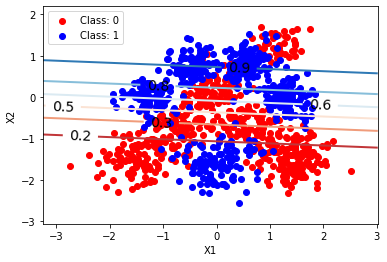

In [41]:
plot_predictive_distribution(X_b, Y_b, beta_map)

In [42]:
def plot_bayesian_predictive_distribution(x, y, betas, cov, diff=0.5, map_inputs = lambda x : x):
    plot_classes_2D(x, y, colours)
    x_min, x_max = x[ :, 0 ].min() - diff, x[ :, 0 ].max() + diff
    y_min, y_max = x[ :, 1 ].min() - diff, x[ :, 1 ].max() + diff
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    ax = plt.gca()
    new_x_tilde = create_X_tilde(map_inputs(np.concatenate((xx.ravel().reshape((-1, 1)), yy.ravel().reshape((-1, 1))), 1)))
    Z = predictive_distribution(new_x_tilde, betas, cov)
    Z = Z.reshape(xx.shape)
    cs2 = ax.contour(xx, yy, Z, cmap = 'RdBu', linewidths = 2)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 14)
    plt.show()

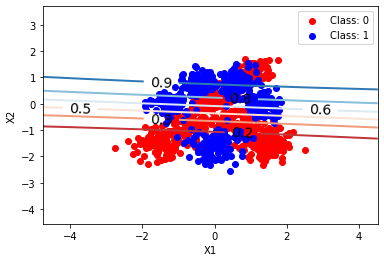

In [43]:
plot_bayesian_predictive_distribution(X_b, Y_b, beta_map, cov_matrix, diff=2)

## Bayesian logistic classification with radial basis functions

In [44]:
l = 0.1
inverse_prior_variance = 1
X_tilde_train_rbf = create_X_tilde(evaluate_basis_functions(l, X_train_b, X_train_b))
X_tilde_test_rbf = create_X_tilde(evaluate_basis_functions(l, X_test_b, X_train_b))
X_tilde_rbf = create_X_tilde(evaluate_basis_functions(l, X_b, X_train_b))

In [45]:
beta_map_rbf = get_beta_map(X_tilde_train_rbf, Y_train_b, inverse_prior_variance)[0]

In [46]:
inv_cov_matrix_rbf = calc_log_Hessian(beta_map_rbf, X_tilde_train_rbf, inverse_prior_variance)
cov_matrix_rbf = np.linalg.inv(inv_cov_matrix_rbf)

In [47]:
str(beta_map_rbf[:10]) + " ...."

'[-0.26385799  0.39288324 -0.36629567 -0.43709911 -0.43819481 -0.45292054\n  0.45216245 -0.38590104 -0.39449596  0.46861789] ....'

In [66]:
cov_matrix_rbf

array([[ 2.99074121e-02, -3.48315380e-03, -3.61943074e-03, ...,
        -3.26629003e-03, -2.21201795e-03, -4.25576834e-03],
       [-3.48315380e-03,  8.79361222e-01,  4.23781132e-04, ...,
         3.80406749e-04,  5.16609049e-04,  5.08382947e-04],
       [-3.61943074e-03,  4.23781132e-04,  8.87586407e-01, ...,
         3.96147246e-04,  2.67625005e-04,  5.14949028e-04],
       ...,
       [-3.26629003e-03,  3.80406749e-04,  3.96147246e-04, ...,
         8.88677296e-01,  2.41575906e-04,  4.64787079e-04],
       [-2.21201795e-03,  5.16609049e-04,  2.67625005e-04, ...,
         2.41575906e-04,  9.24716100e-01,  3.14756970e-04],
       [-4.25576834e-03,  5.08382947e-04,  5.14949028e-04, ...,
         4.64787079e-04,  3.14756970e-04,  8.76811930e-01]])

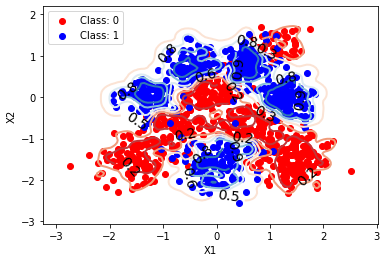

In [49]:
plot_predictive_distribution(X_b, Y_b, beta_map_rbf, map_inputs=lambda x : evaluate_basis_functions(l, x, X_train_b))

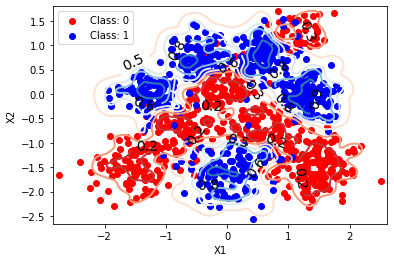

In [50]:
plot_bayesian_predictive_distribution(X, Y, beta_map_rbf, cov_matrix_rbf, diff=0.1, map_inputs=lambda x : evaluate_basis_functions(l, x, X_train_b))

### Metrics
Naturally, we should investigate the performance of this new model.

In order to calculate the likelihoods we make use of the form:

$L = \sum_n \; y^{(n)} log \: p( x^{(n)}\in C_1) + (1-y^{(n)})log\:(1 - p(x^{(n)}\in C_1))$

In the first part of this notebook, our probabilities came from the logistic function - and we can further use this to calculate the likelihood for $\beta ^{MAP}$. Then, in the case of our full Bayesian classifier, we can use the output of the predictive distribution.

In [51]:
print("Logistic model using beta_map\n")
print("Training likelihood: " + str(calc_likelihood(beta_map_rbf, X_tilde_train_rbf, Y_train)/Y_train.shape[0]))
print("Test likelihood: " + str(calc_likelihood(beta_map_rbf, X_tilde_test_rbf, Y_test)/Y_test.shape[0]))

Logistic model using beta_map

Training likelihood: -1.191110101338839
Test likelihood: -1.1205135648517281


In [52]:
train_pred = predictive_distribution(X_tilde_train_rbf, beta_map_rbf, inv_cov_matrix_rbf)
test_pred = predictive_distribution(X_tilde_test_rbf, beta_map_rbf, inv_cov_matrix_rbf)

In [53]:
print("Laplace approximation\n")
print("Training likelihood: "+str(np.sum(Y_train_b * np.log(train_pred) + (1-Y_train_b) * np.log(1-train_pred))/Y_train.shape[0]))
print("Test likelihood: "+str(np.sum(Y_test_b * np.log(test_pred) + (1-Y_test_b) * np.log(1-test_pred))/Y_test.shape[0]))

Laplace approximation

Training likelihood: -0.5619180719630854
Test likelihood: -0.5934812199839119


It may seem as though we have made the model worse by doing all this complicated Bayesian stuff, but we have to consider that of course the ***Maximum Likelihood*** is going to perform best when we measure using the likelihood!

Let's check the confusion matrix for the logistic predictive distribution using the values of $\beta^{MAP}$.

In [54]:
confusion_matrix(Y_test_b, decision(predict(X_tilde_test_rbf, beta_map_rbf)))

array([[0.43 , 0.045],
       [0.075, 0.45 ]])

Then let us check the confusion matrix for the Bayesian predictive distribution from the Laplace approximation.

In [55]:
confusion_matrix(Y_test_b, decision(predictive_distribution(X_tilde_test_rbf, beta_map_rbf, inv_cov_matrix_rbf)))

array([[0.43 , 0.045],
       [0.075, 0.45 ]])

Note that they perform exactly the same! This is because we set our decision boundary at 0.5 and so $\mu_a = 0$ -  we are using the MAP decision boundary after marginalising.

These results are roughly on par with the best performing maximum likelihood models, perhaps a bit below based on my first running. It's plausible that this is down to the fact that our MAP optimisation function can return wildly different results.

## Optimising for Model Evidence

Our model evidence can be approximated as the normalising constant for our Laplace approximation. As the approximate distribution is Gaussian, we can easily calculate this constant as:

$Z = f(\underline{\beta}^{MAP})(2\pi)^{\frac{d}{2}}|C|^{\frac{1}{2}}$ where $C$ is our covariance matrix.

In [67]:
np.power(np.sqrt(2*np.pi * np.power(np.linalg.det(inv_cov_matrix_rbf), 1/801)), 801)
## this calculation will blow up if we aren't careful

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in power
  """Entry point for launching an IPython kernel.


inf

Errr, it makes sense that as $d$ (our number of weights) increases, this will blow up. Thankfully, for the purposes of maximising this evidence we can use logs.

$logZ = logf(\underline{\beta}^{MAP}) + \frac{d}{2}log2\pi + \frac{1}{2}log|C|$

In [77]:
def log_model_evidence(x_tilde, y, betas, covariance, var_prior):
    #evaluate estimate for model evidence at beta_map
    f_beta_map = np.log(calc_posterior(betas, x_tilde, y, var_prior))
    det_sign, root_det = np.linalg.slogdet(covariance) # use slogdet as we expect the covariance to have a very small determinant
    pi_factor = betas.shape[0]/2 * np.log(np.pi * 2)
    
    return (f_beta_map + pi_factor + 0.5*root_det)

In [78]:
log_model_evidence(X_tilde_rbf, Y_b, beta_map_rbf, cov_matrix_rbf, inverse_prior_variance)

664.9026539281479

In [274]:
lengths = np.array([0.1*i for i in range(1, 11)])
inverse_variances = np.array([0.01*i for i in range(1, 11)])

In [275]:
xx, yy = np.meshgrid(inverse_variances, lengths) #xx -> lambdas, yy -> els

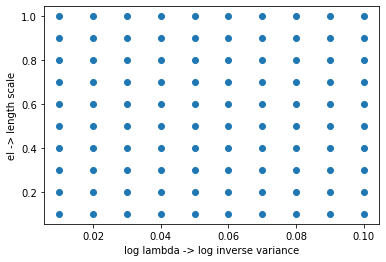

In [276]:
plt.scatter((xx), (yy))
plt.xlabel("log lambda -> log inverse variance")
plt.ylabel("el -> length scale")
plt.show()

In [277]:
def get_bayesian_evidence(x, y, length_scale, inv_var):
    x_train, x_test, y_train, y_test = skms.train_test_split(x, y, train_size=0.8)
    x_tilde_train_rbf = create_X_tilde(evaluate_basis_functions(length_scale, x_train, x_train))
    x_tilde_rbf = create_X_tilde(evaluate_basis_functions(length_scale, x, x_train))
    
    map_beta = get_beta_map(x_tilde_train_rbf, y_train, inv_var)[0]
    inverse_covariance_matrix = calc_log_Hessian(map_beta, x_tilde_train_rbf, inv_var)
    covariance_matrix = np.linalg.inv(inverse_covariance_matrix)
    
    evidence = log_model_evidence(x_tilde_rbf, y, map_beta, covariance_matrix, inv_var)
    return evidence


In [278]:
evidences = np.ones([10, 10])

In [279]:
for i in range(10):
    for j in range(10):
        evidences[i][j] = get_bayesian_evidence(X_b, Y_b, yy[i][j], xx[i][j])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


In [280]:
evidences

array([[1958.77593728, 2079.1730119 , 1923.20530149, 1730.97844152,
        1742.18158449, 1672.97335491, 1623.40225376, 1575.76974361,
        1527.48803186, 1489.30197533],
       [2389.77294314, 2155.14502706, 1996.83611252, 1897.6785221 ,
        1818.3315462 , 1743.11389184, 1696.71516633, 1632.99508217,
        1590.32196665, 1561.3035952 ],
       [2405.21232065, 2142.72107164, 1997.07746141, 1914.14979983,
        1820.72160203, 1767.55599149, 1709.10772826, 1655.09651615,
        1607.398383  , 1568.21244225],
       [2460.78473847, 2213.98536211, 2056.08245307, 1924.9343082 ,
        1853.43530214, 1775.02426046, 1718.71686168, 1671.4293728 ,
        1639.29199143, 1582.97249407],
       [2472.39203289, 2211.56203833, 2064.31342157, 1954.78265399,
        1860.48382286, 1789.68316458, 1740.80635293, 1686.96513014,
        1632.9826036 , 1601.65206613],
       [2492.34101937, 2216.76634373, 2070.74349078, 1955.45199525,
        1875.92395901, 1799.92213249, 1742.63208817, 1691

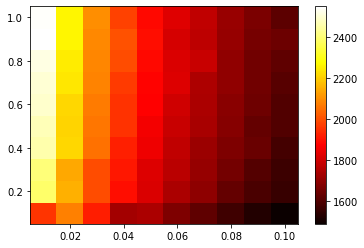

In [281]:
xu = inverse_variances
yu = lengths
x_appended = np.append(xu , [xu[-1]+np.diff(xu)[-1]])-np.diff(xu)[-1]/2.
y_appended = np.append(yu , [yu[-1]+np.diff(yu)[-1]])-np.diff(yu)[-1]/2.
axis_x, axis_y = np.meshgrid(x_appended, y_appended)
plt.pcolormesh(axis_x, axis_y, evidences, cmap='hot')
plt.colorbar()
plt.show()

In [282]:
argmax = (int(str(np.nanargmax(evidences.ravel()))[0]), np.nanargmax(evidences.ravel())%10)

In [283]:
argmax

(8, 0)

In [284]:
tuned_var = xx[argmax[0]][argmax[1]]
tuned_var

0.01

In [285]:
tuned_length = yy[argmax[0]][argmax[1]]
tuned_length

0.9

In [286]:
evidences[argmax[0]][argmax[1]]

2548.7755416477744

### Checking the results

In [287]:
X_tilde_train_tuned = create_X_tilde(evaluate_basis_functions(tuned_length, X_train_b, X_train_b))
X_tilde_test_tuned = create_X_tilde(evaluate_basis_functions(tuned_length, X_test_b, X_train_b))
X_tilde_tuned = create_X_tilde(evaluate_basis_functions(tuned_length, X_b, X_train_b))

In [288]:
beta_map_tuned = get_beta_map(X_tilde_train_rbf, Y_train_b, inverse_prior_variance)[0]

In [289]:
inv_cov_matrix_tuned = calc_log_Hessian(beta_map_tuned, X_tilde_train_tuned, tuned_var)
cov_matrix_tuned = np.linalg.inv(inv_cov_matrix_tuned)

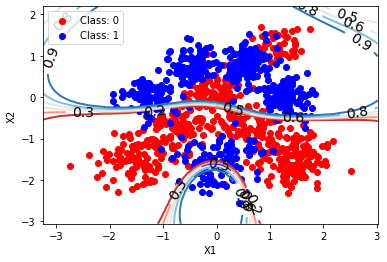

In [290]:
plot_predictive_distribution(X_b, Y_b, beta_map_tuned, map_inputs=lambda x : evaluate_basis_functions(tuned_length, x, X_train_b))

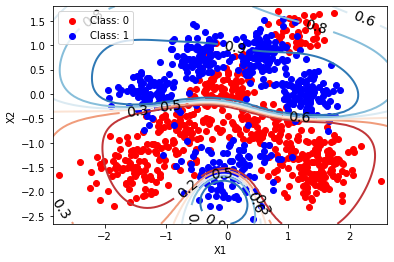

In [291]:
plot_bayesian_predictive_distribution(X_b, Y_b, beta_map_tuned, cov_matrix_tuned, diff=0.1, map_inputs=lambda x : evaluate_basis_functions(tuned_length, x, X_train_b))

In [292]:
confusion_matrix(Y_test_b, decision(predict(X_tilde_test_tuned, beta_map_tuned)))

array([[0.35 , 0.125],
       [0.085, 0.44 ]])

In [293]:
confusion_matrix(Y_test_b, decision(predictive_distribution(X_tilde_test_tuned, beta_map_tuned, inv_cov_matrix_tuned)))

array([[0.35 , 0.125],
       [0.085, 0.44 ]])